In [2]:
import petsc4py
petsc4py.init(['-saws_port_auto_select'])

In [3]:
import dolfinx as df
import dolfinx.fem.petsc
import ufl
import basix
from mpi4py import MPI

from pathlib import Path
from typing import Dict

cache_dir = f"/cluster/scratch/mpundir/dolfinx-cache/"
print(f"Directory to put C files in: {cache_dir}")

jit_options = {
    "cffi_extra_compile_args": ["-O3", "-march=native"],
    "cache_dir": cache_dir,
    "cffi_libraries": ["m"],
}

Directory to put C files in: /cluster/scratch/mpundir/dolfinx-cache/


In [4]:
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

In [5]:
import numpy as np

from nanomesh import Image
from nanomesh import Mesher2D

In [6]:
structure = np.load("./figs/blurred_lattice.npy")
structure = np.where(structure < 0.725, 0, 1)
H, L = structure.shape
size = np.minimum(H, L)
if size % 2 == 0:
    size = size - 1
structure = structure[:size, :size]

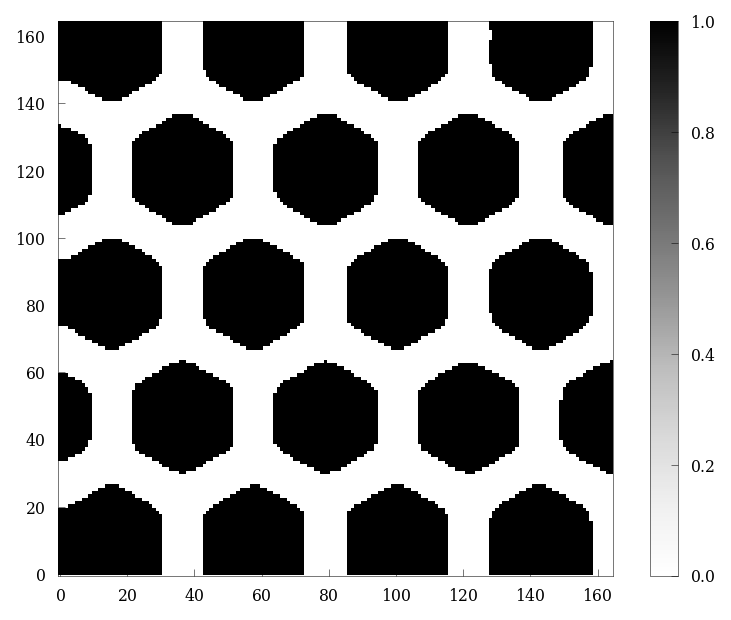

In [7]:
cb = plt.imshow(structure, origin="lower", cmap="Greys")
plt.colorbar(cb)
plt.show()

## creating a large structure for FE analysis

In [8]:
"""conc_structure = np.concatenate((structure, np.fliplr(structure)), axis=1)
conc_structure = np.concatenate((conc_structure, np.flipud(conc_structure)[16:, :]), axis=0)
conc_structure = np.concatenate((conc_structure, conc_structure[:, 30:]), axis=1)
conc_structure = np.concatenate((conc_structure, np.flipud(conc_structure)[18:, :]), axis=0)
conc_structure = np.concatenate((conc_structure, conc_structure[:, 30:]), axis=1)
conc_structure = np.concatenate((conc_structure, np.flipud(conc_structure)[18:, :]), axis=0)"""

conc_structure = structure

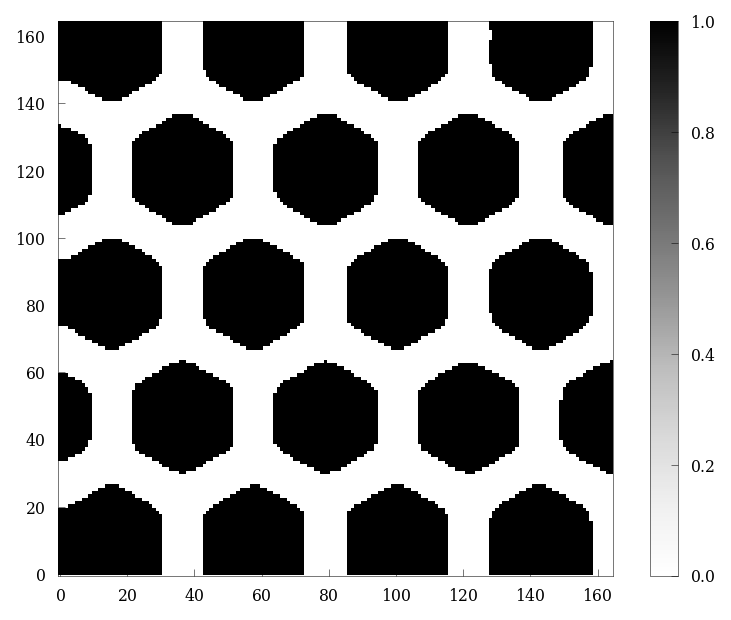

In [9]:
cb = plt.imshow(conc_structure, origin="lower", cmap="Greys")
plt.colorbar(cb)
plt.show()

## meshing the structure

<Axes: xlabel='x', ylabel='y'>

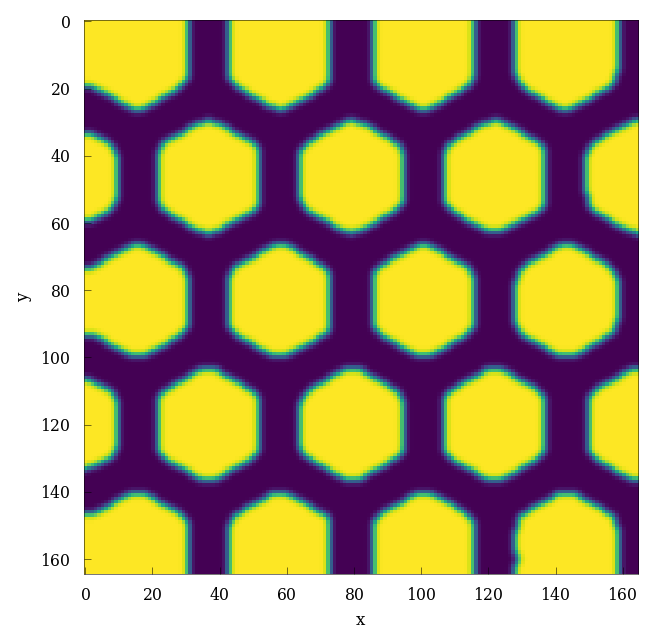

In [10]:
plane = Image(conc_structure).gaussian(sigma=1)
plane.show()

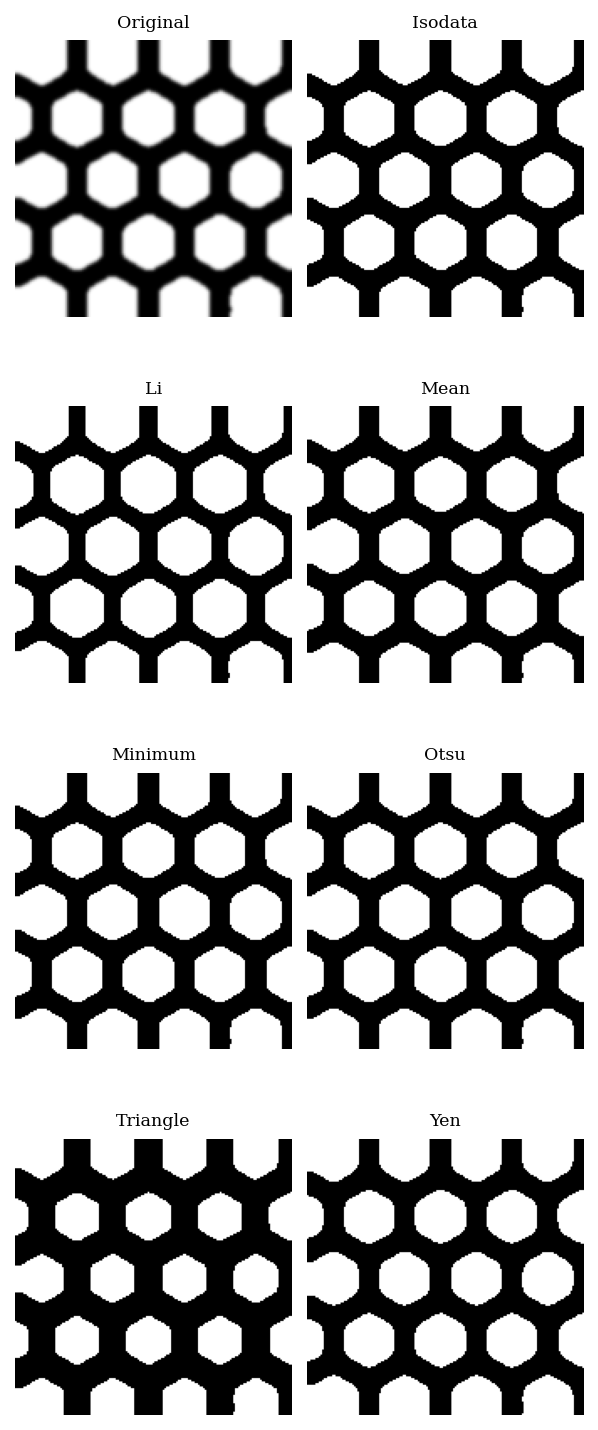

In [11]:
plane.try_all_threshold(figsize=(4, 10))

In [12]:
local_thresh = plane.threshold(method="li")
seg_local = plane > local_thresh

<Axes: title={'center': 'line mesh'}>

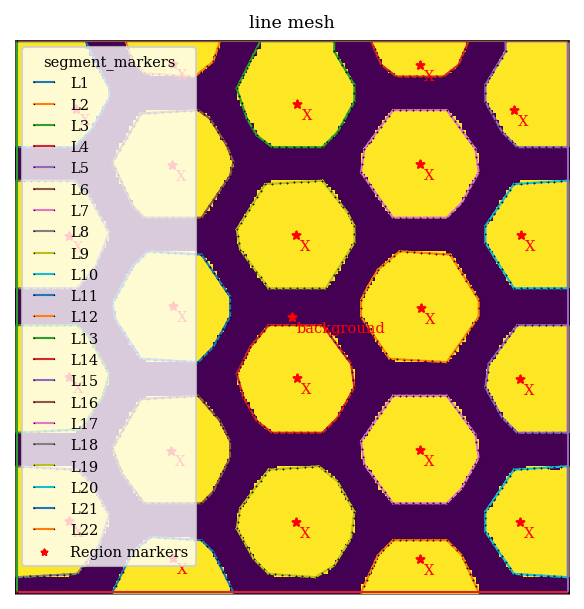

In [13]:
mesher = Mesher2D(
    seg_local.image.T
)  # to be connsitent in orientation when creating mesh, otherwise flips
mesher.generate_contour(max_edge_dist=2)
mesher.plot_contour()

In [14]:
mesh = mesher.triangulate(opts="q30a400")

<Axes: title={'center': 'triangle mesh'}>

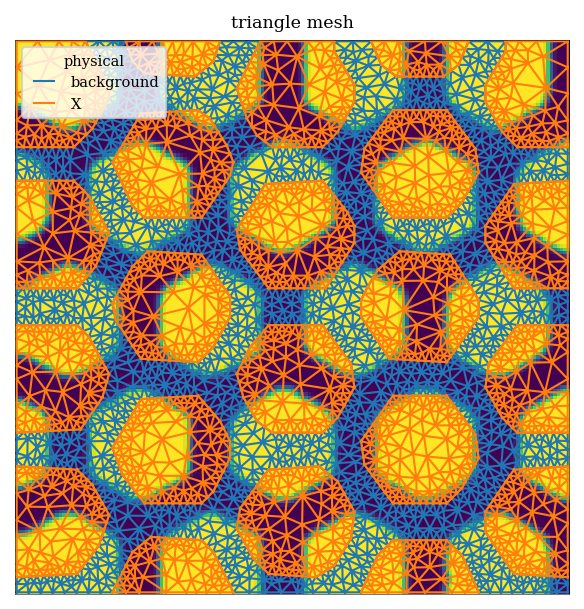

In [15]:
plane.compare_with_mesh(mesh)

<Axes: title={'center': 'triangle mesh'}>

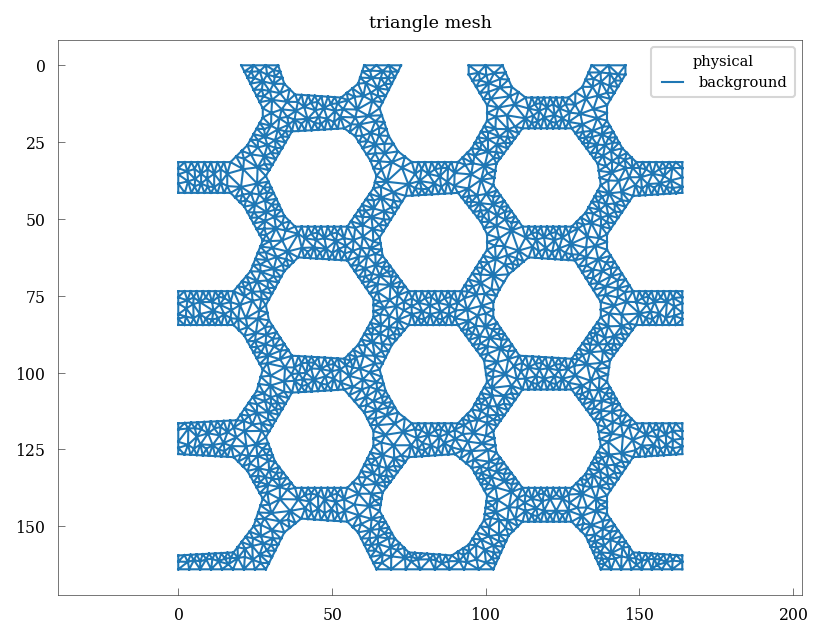

In [16]:
triangles = mesh.get("triangle")
triangles.remove_cells(label=2, key="physical")
triangles.plot()

In [17]:
np.sum(1 - conc_structure) / conc_structure.shape[0] / conc_structure.shape[0]

0.4636914600550964

In [18]:
np.sum(1 - seg_local.image) / seg_local.image.shape[0] / seg_local.image.shape[0]

0.4055096418732782

In [19]:
dx = 1.0
triangles.points *= dx

In [20]:
meshio_mesh = triangles.to_meshio()
meshio_mesh.write("./additional_data/mesh.xdmf")

with df.io.XDMFFile(MPI.COMM_WORLD, "./additional_data/mesh.xdmf", "r") as xdmf:
    domain = xdmf.read_mesh(name="Grid")

/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "



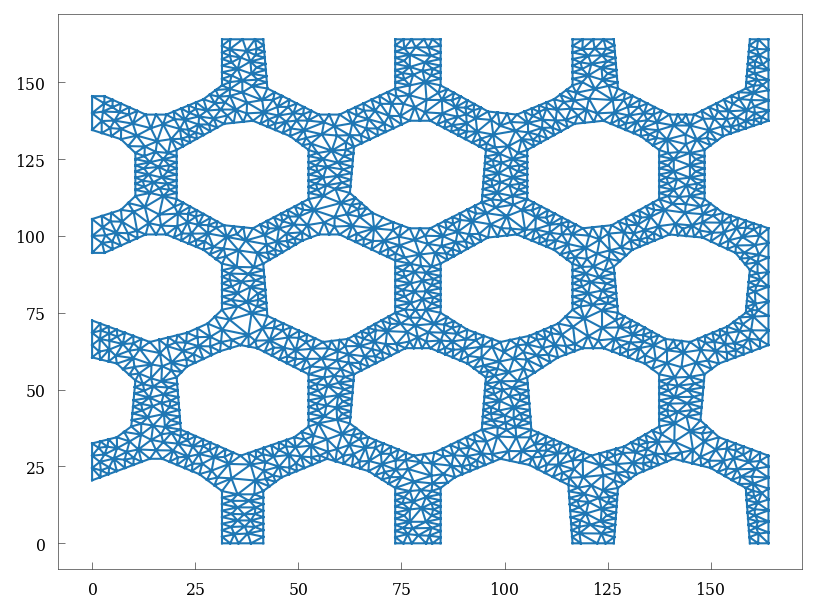

In [21]:
topology, cell_types, geometry = df.plot.vtk_mesh(domain, 2)
tricells = topology.reshape((-1, 4))[:, 1:]
plt.triplot(geometry[:, 0], geometry[:, 1], tricells)

## setting up FEniCSx problem 

In [22]:
gdim = domain.geometry.dim
dim = domain.topology.dim

In [23]:
degree = 2  # linear interpolation function space
shape = (dim,)  # this means we want a vector field of size `dim`
cg1 = basix.ufl.element("Lagrange", domain.topology.cell_name(), 1, shape=shape)

In [24]:
V = df.fem.functionspace(domain, cg1)

u_sol = df.fem.Function(V, name="Displacement")

In [25]:
lmbda = df.fem.Constant(domain, 1.0)
mu = df.fem.Constant(domain, 1.0)


def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

In [26]:
def mark_entities(domain, dim, entities_dict):
    """Mark entities of specified dimension according to a geometrical marker function

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    dim : int
        Dimension of the entities to mark
    entities_dict : dict
        A dictionary mapping integer tags with a geometrical marker function {tag: marker(x)}

    Returns
    -------
    entities_tag array
    """
    marked_values = []
    marked_entities = []
    # number of non-ghosted entities
    num_entities_local = domain.topology.index_map(dim).size_local
    # Concatenate and sort the arrays based on indices
    for tag, location in entities_dict.items():
        entities = df.mesh.locate_entities(domain, dim, location)
        entities = entities[entities < num_entities_local]  # remove ghost entities
        marked_entities.append(entities)
        marked_values.append(np.full_like(entities, tag))
    marked_entities = np.hstack(marked_entities)
    marked_values = np.hstack(marked_values)
    sorted_entities = np.argsort(marked_entities)
    entities_tags = df.mesh.meshtags(
        domain, dim, marked_entities[sorted_entities], marked_values[sorted_entities]
    )
    return entities_tags

In [27]:
height = np.max(domain.geometry.x[:, 1])
width = np.max(domain.geometry.x[:, 0])

In [28]:
def top(x):
    return np.isclose(x[1], height)


def bottom(x):
    return np.isclose(x[1], 0)


def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], width)

In [29]:
fdim = domain.topology.dim - 1
domain.topology.create_entities(fdim)
facet_tags = mark_entities(domain, fdim, {1: top, 2: bottom})
print(facet_tags.values)

[2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 1 2 2 2 2 1 1 1 1 2 2 1 1]


In [30]:
dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": 2*degree-1, "quadrature_scheme": "default"},
)
ds = ufl.Measure(
    "ds",
    domain=domain,
    subdomain_data=facet_tags,
    metadata={"quadrature_degree": 2*degree-1, "quadrature_scheme": "default"},
)

In [31]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

f = df.fem.Constant(domain, np.array([0, 0], dtype=float))

a = ufl.inner(sigma(u), epsilon(v)) * dx
L = ufl.inner(f, v) * dx

## defining boundary conditions

In [32]:
top_dofs = df.fem.locate_dofs_geometrical(V, top)
bottom_dofs = df.fem.locate_dofs_geometrical(V, bottom)
left_dofs = df.fem.locate_dofs_geometrical(V, left)
right_dofs = df.fem.locate_dofs_geometrical(V, right)

## setting up functions to compute stress and strain values at each quadrature points

In [34]:
deg_quad = 2  # quadrature degree for internal state variable representation

basix_celltype = getattr(basix.CellType, domain.topology.cell_type.name)
quadrature_points, weights = basix.make_quadrature(basix_celltype, deg_quad)

map_c = domain.topology.index_map(domain.topology.dim)
num_cells = map_c.size_local + map_c.num_ghosts
cells = np.arange(0, num_cells, dtype=np.int32)
ngauss = num_cells * len(weights)

eps_expr = df.fem.Expression(epsilon(u_sol), quadrature_points)

sig_expr = df.fem.Expression(sigma(u_sol), quadrature_points)


def eval_at_quadrature_points(expression):
    return expression.eval(domain, cells).reshape(ngauss, -1)

## checking the relative density of the structure used for FE simulation

In [35]:
relative_density = (
    df.fem.assemble_scalar(df.fem.form(df.fem.Constant(domain, 1.0) * dx))
    / height
    / width
)
print("The relative density of the lattice structure", relative_density)

The relative density of the lattice structure 0.41378829565735054


## defining a function that solves the lattice material for a given boundary codntions and returns stress-strain

We apply Kinematic Uniform Boundary Conditions (KUBC) for computational homogenization. It assumes that the strain field is uniform on the boundary of the RVE. 

For a homogenized material the strain, strain relation in Voigt notation is given as:

$ \overline{\boldsymbol{\sigma}}  = \overline{\boldsymbol{C}} : \overline{\boldsymbol{\varepsilon}}  $

We express the macroscopic strain as a Identity tensor such that:

$ \overline{\boldsymbol{\varepsilon}} =  \begin{bmatrix} \varepsilon_{xx} & 0 & 0 \\  0 & \varepsilon_{yy} & 0   \\  0 & 0 & 2 \varepsilon_{xy} \end{bmatrix} =  \boldsymbol{I}$

This means that under such condition the macroscopic compliance matrix will be equal to average stress. Therefore, 

$ \overline{\boldsymbol{C}} = \begin{bmatrix} C_{xxxx} &  & \\ & C_{yyyy} & \\ & & C_{xyxy} \end{bmatrix} = \begin{bmatrix} \overline{\sigma}_{xx} &  & \\ &  \overline{\sigma}_{yy} &  \\ & &  \overline{\sigma}_{xy} \end{bmatrix}$

To compute the values of $\overline{\sigma}_{xx}, \overline{\sigma}_{yy}$ and $ \overline{\sigma}_{xy}$, we perform 3 FE simulations with 3 different boundary conditions. The microscale stresses for each boundary conditions are then average over the volme of the RVE

$\overline{\sigma}_{ij} = \dfrac{\int  \sigma_{ij}(x) dV}{\Omega_\text{RVE}}$

For a 2D case, we need 3 boundary conditions:
- uniaxial strain along $y$-axis
- uniaxial strain along $x$-axis
- simple shear strain


For our analysis we use a value $10^{-1}$ for every macroscopic strain component.

In [36]:
def compute_micro_stress_strain(bcs):
    u_sol.vector.set(0.0)

    problem = df.fem.petsc.LinearProblem(
        a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    problem.solve()

    eps_values = eval_at_quadrature_points(eps_expr)
    sig_values = eval_at_quadrature_points(sig_expr)

    return eps_values, sig_values

## applying various boundary conditions

### uniaxial strain along y-axis

In [85]:
V_uy, mapping = V.sub(1).collapse()
bottom_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), bottom)
top_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), top)
left_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), left)
right_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), right)


V_ux, mapping = V.sub(0).collapse()
bottom_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), bottom)
top_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), top)
left_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), left)
right_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), right)

#V_u, mapping = V.sub(0).collapse()
left_dofs_u = df.fem.locate_dofs_geometrical((V.sub(0), V_u), left)
right_dofs_u = df.fem.locate_dofs_geometrical((V.sub(0), V_u), right)


V_u1, mapping = V.sub(1).collapse()
left_dofs_u1 = df.fem.locate_dofs_geometrical((V.sub(1), V_u1), left)
right_dofs_u1 = df.fem.locate_dofs_geometrical((V.sub(1), V_u1), right)

macro_strain = 1e-1

uD_zeros = df.fem.Function(V_uy)
uD_applied = df.fem.Function(V_uy)
uD_applied.interpolate(lambda x: x[1] * macro_strain)

uDx_zeros = df.fem.Function(V_ux)

uDx_side_zeros = df.fem.Function(V_u)

uD1_applied = df.fem.Function(V_u1)
uD1_applied.interpolate(lambda x: x[1] * macro_strain)


bcs = [
    df.fem.dirichletbc(uD_applied, top_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_applied, bottom_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uDx_zeros, bottom_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDx_zeros, top_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDx_zeros, left_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDx_zeros, right_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uD_applied, left_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_applied, right_dofs_uy, V.sub(1)),
]

In [86]:
eps_values, sig_values = compute_micro_stress_strain(bcs)
C_yyyy = (
    df.fem.assemble_scalar(df.fem.form(sigma(u_sol)[1, 1] * dx))
    / height
    / width
    / macro_strain
)
print(C_yyyy)

0.5702661107570886


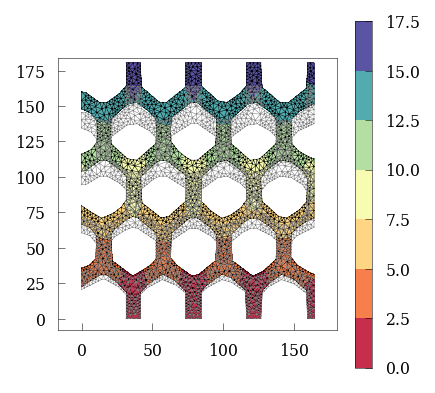

In [87]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)
x = u_geometry
tricells = u_topology.reshape((-1, 4))[:, 1:]
u_mat = u_sol.x.array.reshape(-1, 2)

plt.figure(figsize=(3, 3))
ax = plt.axes()

ax.triplot(
    geometry[:, 0], geometry[:, 1], tricells, color="gray", linewidth=0.25, zorder=20
)

ax.triplot(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    zorder=10,
    color="k",
    linewidth=0.25,
)
im = ax.tricontourf(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    u_mat[:, 1],
    cmap="Spectral",
    vmin=np.min(u_mat[:, 1]),
    vmax=np.max(u_mat[:, 1]),
)
ax.set_xlim(-0.1 * width, 1.1 * width)
ax.set_ylim(-0.05 * height, 1.12 * height)
ax.set_aspect("equal")
plt.colorbar(im)
plt.show()

### uniaxial strain along x-axis

In [93]:
V_ux, mapping = V.sub(0).collapse()
left_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), left)
right_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), right)
top_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), top)
bottom_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), bottom)


V_uy, mapping = V.sub(1).collapse()
left_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), left)
right_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), right)
top_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_u), top)
bottom_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_u), bottom)

'''V_u, mapping = V.sub(1).collapse()
top_dofs_u = df.fem.locate_dofs_geometrical((V.sub(1), V_u), top)
bottom_dofs_u = df.fem.locate_dofs_geometrical((V.sub(1), V_u), bottom)


V_u0, mapping = V.sub(0).collapse()
top_dofs_u0 = df.fem.locate_dofs_geometrical((V.sub(0), V_u0), top)
bottom_dofs_u0 = df.fem.locate_dofs_geometrical((V.sub(0), V_u0), bottom)'''

macro_strain = 1e-1

uD_zeros = df.fem.Function(V_ux)
uD_applied = df.fem.Function(V_ux)
uD_applied.interpolate(lambda x: x[0] * macro_strain)


'''uDy_zeros = df.fem.Function(V_uy)

uDy_top_zeros = df.fem.Function(V_u)


uD0_applied = df.fem.Function(V_u0)
uD0_applied.interpolate(lambda x: x[0] * macro_strain)'''


bcs = [
    df.fem.dirichletbc(uD_applied, right_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uD_applied, left_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uD_zeros, left_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_zeros, right_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_zeros, top_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_zeros, bottom_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uD_applied, top_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uD_applied, bottom_dofs_ux, V.sub(0)),
]

In [94]:
eps_values, sig_values = compute_micro_stress_strain(bcs)
C_xxxx = (
    df.fem.assemble_scalar(df.fem.form(sigma(u_sol)[0, 0] * dx))
    / height
    / width
    / macro_strain
)
print(C_xxxx)

0.5225914792860634


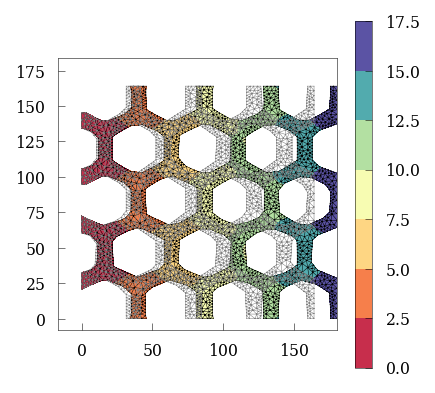

In [95]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)
x = u_geometry
tricells = u_topology.reshape((-1, 4))[:, 1:]
u_mat = u_sol.x.array.reshape(-1, 2)

plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.triplot(
    geometry[:, 0], geometry[:, 1], tricells, color="gray", linewidth=0.25, zorder=20
)

ax.triplot(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    zorder=10,
    color="k",
    linewidth=0.25,
)
im = ax.tricontourf(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    u_mat[:, 0],
    cmap="Spectral",
    vmin=np.min(u_mat[:, 0]),
    vmax=np.max(u_mat[:, 0]),
)
ax.set_xlim(-0.1 * width, 1.1 * width)
ax.set_ylim(-0.05 * height, 1.12 * height)
ax.set_aspect("equal")
plt.colorbar(im)
plt.show()

### simple shear strain 

In [109]:
V_ux, mapping = V.sub(0).collapse()
left_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), left)
right_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), right)
top_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), top)
bottom_dofs_ux = df.fem.locate_dofs_geometrical((V.sub(0), V_ux), bottom)

V_uy, mapping = V.sub(1).collapse()
bottom_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), bottom)
top_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), top)
left_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), left)
right_dofs_uy = df.fem.locate_dofs_geometrical((V.sub(1), V_uy), right)


macro_strain = 0.5e-1

uDy_applied = df.fem.Function(V_uy)
uDy_applied.interpolate(lambda x: x[0] * macro_strain)

uDx_applied = df.fem.Function(V_ux)
uDx_applied.interpolate(lambda x: x[1] * macro_strain)

bcs = [
    df.fem.dirichletbc(uDx_applied, right_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDx_applied, left_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDy_applied, top_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uDy_applied, bottom_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uDx_applied, top_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDx_applied, bottom_dofs_ux, V.sub(0)),
    df.fem.dirichletbc(uDy_applied, left_dofs_uy, V.sub(1)),
    df.fem.dirichletbc(uDy_applied, right_dofs_uy, V.sub(1)),
    
]

In [110]:
eps_values, sig_values = compute_micro_stress_strain(bcs)
C_xyxy = (
    df.fem.assemble_scalar(df.fem.form(sigma(u_sol)[0, 1] * dx))
    / height
    / width
    / (2 * macro_strain)
)
print(C_xyxy)

0.15230863648241505


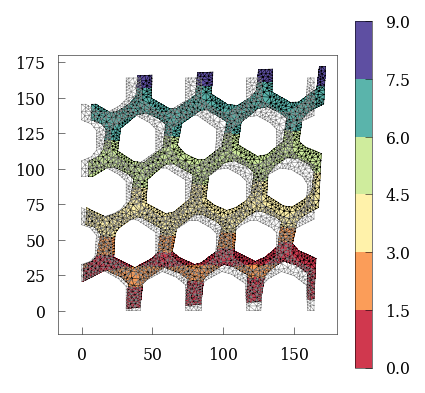

In [53]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)
x = u_geometry
tricells = u_topology.reshape((-1, 4))[:, 1:]
u_mat = u_sol.x.array.reshape(-1, 2)

plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.triplot(
    geometry[:, 0], geometry[:, 1], tricells, color="gray", linewidth=0.25, zorder=20
)
ax.triplot(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    zorder=10,
    color="k",
    linewidth=0.25,
)
im = ax.tricontourf(
    x[:, 0] + u_mat[:, 0],
    x[:, 1] + u_mat[:, 1],
    tricells,
    u_mat[:, 0],
    cmap="Spectral",
    vmin=np.min(u_mat[:, 0]),
    vmax=np.max(u_mat[:, 0]),
)
ax.set_xlim(-0.1 * width, 1.1 * width)
ax.set_ylim(-0.1 * height, 1.1 * height)
ax.set_aspect("equal")

plt.colorbar(im)
plt.show()

In [57]:
bulk = float(lmbda) + 2*float(mu)/3.

In [67]:
bulk_voigt = relative_density*bulk
mu_voigt = relative_density*mu
lmbda_voigt = float(bulk_voigt - 2*mu_voigt/3)

bulk_reuss = 1/(relative_density/bulk)
mu_reuss = 1/(relative_density/mu)
lmbda_reuss = float(bulk_reuss - 2*mu_reuss/3)

In [68]:
lmbda_voigt

0.4137882956573505

In [69]:
lmbda_reuss

2.4166947458274146

In [70]:
C_xxxx

0.5225914792860634

In [72]:
C_xxxx- 2*C_xyxy

0.21797420632123332